# Marine Geology & Geophysics (MGG)

<img src="WorldEarthquakeMap-1-1400x820.jpeg">

This tutorial is part of our Marine Geology and Geophysics day. It demonstrates how to do basic analysis and visualization of seafloor features, geologic, and seismic data. We will learn how to make maps of publicly available datasets of seafloor bathymetry, crustal age, and tectonic plate depth. We will then learn how to download data using python from the databases where seismic data are stored. Combining these techniques, we will learn to think like a geophysicist and use available data to draw connections between earthquake activity and geologic characteristics.

### Estimated tutorial time: 2 hours

## Tutorial Goals

Python Skills
  *   Download data from a remote database using URL queries
  *   Make interactive plots that can be embedded with html
  *   Plot detailed and attractive maps using both grid and point data
  *   Co-locate datasets

MG&G Knowledge
  *   Learn about how bathymetry is influenced by earth processes
  *   Understand how earthquake data are stored and used
  *   Visualize how earthquakes are tied to tectonic processes


## Data

- Earthquakes: the vast majority of seismic data is stored by IRIS, the Incorporated Research Institutions for Seismology.
- Bathymetry: the Global Multi-Resolution Topography (GMRT) synthesis is a multi-resolutional compilation of edited multibeam sonar data  https://www.gmrt.org
- Slab depth: Slab2 data is publicly available and can be downloaded at https://www.sciencebase.gov/catalog/item/5aa1b00ee4b0b1c392e86467/

## Reading

Yeats, R. S. (2004). Living with earthquakes in the Pacific Northwest. https://open.oregonstate.education/earthquakes/chapter/earthquakes-in-the-juan-de-fuca-plate/


Bilek, Susan L., Susan Y. Schwartz, and Heather R. DeShon. "Control of seafloor roughness on earthquake rupture behavior." Geology 31.5 (2003): 455-458.

https://pubs.geoscienceworld.org/gsa/geology/article/31/5/455/198278/Control-of-seafloor-roughness-on-earthquake

# Let's start!

## Environment set-up

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr  #loading and working with data in an optimal way.


import obspy
from obspy.clients.fdsn import Client

import plotly.express as px

import wget

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

from matplotlib.colors import LightSource

import os.path # to check if files already exist


# Downloading earthquake data

The vast majority of seismic data is stored by IRIS, the *Incorporated Research Institutions for Seismology*.

IRIS stores seismometer waveform time series, seismometer station information, earthquake catalog data, and many, many, more seismic-related data products.

Much of the data we will be using today comes from IRIS, and we can download it remotely from this python notebook using the Number 1 package in seismology, obsPy!

https://docs.obspy.org/

obsPy connects to seismic databases using a client (see below). There are many other global clients but today we'll be connecting to IRIS. First, we are going to download earthquake data.

In [2]:
# Prepare to connect to the earthquake database, called IRIS
client = Client("IRIS")

In [4]:
# Specify what times you want the data for
t1 = obspy.UTCDateTime(2010,7,1)
t2 = obspy.UTCDateTime(2023,7,1)

# Specify the minimum magnitude earthquake you want
minmagnitude = 6

# Note - you can also specify minimum/maximum latitudes/longitudes to get the data for.
# But for now, we won't specify
minlat = None
maxlat = None
minlon = None
maxlon = None

# Query the earthquake database to create a catalog of earthquakes within your specified timeframe
cat = client.get_events(starttime = t1, 
                        endtime = t2,
                        minmagnitude=minmagnitude,
                        minlatitude=minlat,
                        minlongitude=minlon,
                        maxlatitude=maxlat,
                        maxlongitude=maxlon)

#### We now have a catalog object, which we see contains a number of earthquakes:

In [5]:
cat[1234]

Event:	2014-07-19T14:14:02.290000Z | +11.709,  +57.957 | 6.0  MW

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=4725406")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=24266308")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=182182201")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements

#### We see that we can access individual earthquakes in the catalog by indexing, and we see that they have origin and magnitude information:

In [9]:
N=1232
print('Description', cat[N].event_descriptions[0].text)
print('Magnitude  ', cat[N].magnitudes[0].mag)
print('Time       ', cat[N].origins[0].time.datetime)
print('Depth      ', cat[N].origins[0].depth)
print('Longitude  ', cat[N].origins[0].longitude)
print('Latitude   ', cat[N].origins[0].latitude)

Description FIJI ISLANDS REGION
Magnitude   6.9
Time        2014-07-21 14:54:41
Depth       615400.0
Longitude   -178.4001
Latitude    -19.8015


#### The time, location (lat, lon, depth), and magnitude information is of most interest to us. We can take this information for each earthquake and organize it more neatly into a tabular format as a pandas dataframe.

In [7]:
def catalog2pandas(cat): # Reorganize the Event Catalog into a pandas dataframe, keeping only the needed information
    
    times  = [ev.origins[0].time.datetime for ev in cat]
    lats   = [ev.origins[0].latitude for ev in cat]
    lons   = [ev.origins[0].longitude for ev in cat]
    mags   = [ev.magnitudes[0].mag for ev in cat]
    depths = [ev.origins[0].depth for ev in cat]
    
    descriptions=[ev.event_descriptions[0]['text'] for ev in cat]

    origin_dict = {'time':times,
                   'latitude':lats,
                   'longitude':lons,
                   'depth':depths,
                   'magnitude':mags, 
                   'description':descriptions}

    events = pd.DataFrame.from_dict(origin_dict)
    
    events=events.sort_values(by='time'); 
    
    return events

In [8]:
events=catalog2pandas(cat)
events

,time,latitude,longitude,depth,magnitude,description
1920,2010-07-02 06:04:03.570,-13.6098,166.6541,34400.0,6.3,VANUATU ISLANDS
1919,2010-07-04 21:55:52.370,39.6611,142.5792,30100.0,6.3,"NEAR EAST COAST OF HONSHU, JAPAN"
1918,2010-07-10 11:43:33.000,11.1664,146.0823,16900.0,6.3,SOUTH OF MARIANA ISLANDS
1917,2010-07-12 00:11:20.060,-22.2789,-68.3159,109400.0,6.2,NORTHERN CHILE
1916,2010-07-14 08:32:21.850,-38.0635,-73.4649,25700.0,6.6,NEAR COAST OF CENTRAL CHILE
...,...,...,...,...,...,...
4,2023-06-17 11:26:20.456,-23.4652,-175.4720,22000.0,6.1,TONGA ISLANDS REGION
3,2023-06-18 20:30:22.195,23.1690,-108.6940,10000.0,6.4,GULF OF CALIFORNIA
2,2023-06-18 21:59:17.518,-48.6747,31.1598,10000.0,6.0,SOUTH OF AFRICA
1,2023-06-19 11:18:11.960,-4.4729,144.8345,23844.0,6.2,"NEAR N COAST OF NEW GUINEA, PNG."


# Interactive maps of global earthquakes

#### Now that we have our basic earthquake information, let's visualize where they are in the world! Here we'll make some cool interactive maps that you can access as an html product. To do so we will use the package called plotly.

#### Make a histogram of earthquake magnitudes

In [10]:
# Note: in order to make sure that the plotly figures appear in the jupyter notebook, 
# you may have to execute the following commands:

import plotly.io as pio
pio.renderers.default = 'iframe'

In [11]:
fig = px.histogram(events,   #specify what dataframe to use
             x="magnitude",  #specify the variable for the histogram 
             nbins=50,       #number of bins for the histogram 
             height=400,     #dimensions of the figure
             width=600);
fig.show()

#### Now make an animated map of the earth that iterates through time

Let's add the __year__ and __marker_size__ as new columns to our dataframe to help us visualize earthquakes on a geographic map

In [12]:
events['year'] = pd.DatetimeIndex(events['time']).year # add year as a category to group by
events['marker_size'] =np.fix(np.exp(events['magnitude'])) # add marker size as exp(mag)
events['magnitude bin'] = 0.5*np.fix(2*events['magnitude']) # add marker size as exp(mag)

In [15]:
events2plot=events.loc[events.magnitude>5.5].sort_values(by='year')

fig = px.scatter_geo(events2plot,
                     lat='latitude',lon='longitude', 
                     size='marker_size', color='magnitude',
                     hover_name='description', hover_data=['magnitude','depth', 'year'], 
                     range_color=(6,9),
                     height=800, width=1000,
                     animation_frame="year");
fig.update_geos(resolution=110, showcountries=True)

## In-class exercise \#1: look at all earthquakes on a spinning globe

Use an Orthographic projection to look at all earthquakes on a spinning globe. 

Instructions: 
   - Remove the __animation_frame__ parameter as we want to plot single image. 
   - update_geos with a parameter __projection_type='orthographic'__
   - This time save the interactive figure to html using fig.write_html('filename.html')
   - Download the html file: it can now be embedded in a website!  

In [16]:
#Your solution goes here

As you can see on the interactive maps, a particularly active location is an area off the coast of the northwest United States. To see why this might be, we can look at the topography of the seafloor in that area. We call seafloor topography data "bathymetry".


# Juan de Fuca plate
<img src="Juan de Fuca plate.jpeg" width=800>

Let's zoom in on our location of interest and start to look at the bathymetry of the ocean floor at that location, to see it suggests a connection between the earthquake locations and seafloor features.

Bathymetry datasets are compiled from decades of ship-based seafloor mapping. Scientists work really hard to make this data available to the community. Marine geophysicists primarily get their bathymetry data from the GMRT dataset:

*"The Global Multi-Resolution Topography (GMRT) synthesis is a multi-resolutional compilation of edited multibeam sonar data collected by scientists and institutions worldwide, that is reviewed, processed and gridded by the GMRT Team and merged into a single continuously updated compilation of global elevation data"*


see https://www.gmrt.org/ for more information.

### Building a URL to download data from the GMRT database

In [18]:
# We build a URL which will automatically download a bathymetry grid to our specifications
url = 'https://www.gmrt.org/services/GridServer?north={maxlat}&west={minlon}&east={maxlon}&south={minlat}&layer=topo&format=netcdf&resolution=high' 

# Specify coordinates for the bathymetry grid we want
url=url.format(maxlat=50,
               minlon=-135,
               maxlon=-120,
               minlat=39)

topo_data='GMRTv4_0_20220724topo.grd'

if os.path.isfile(topo_data)==False:
    print('Downloading GMRT topography')
    print(url)
    topo_data=wget.download(url)

print(topo_data)

GMRTv4_0_20220724topo.grd


### The bathymetry is a netcdf file but in a .grd format: let's change it to a more convenient array format.

In [19]:
# Load the downloaded bathymetry data into xarray
topo=xr.open_dataset(topo_data)
dim=np.flip(topo.dimension).values
z=topo.z.values
z=z.reshape(dim)
z[np.isnan(z)]=0;

x=np.linspace(topo.x_range[0],topo.x_range[1],dim[1])
y=np.linspace(topo.y_range[1],topo.y_range[0],dim[0])

### Creating a function that plots nicely the relief data

In [20]:
def plot_elevation(x,y,z, shade=True):
    
    #This deals with specified longitude ranges outside +-180 
    central_longitude=0
    
    if np.max(x)>180: 
        central_longitude=180
    if np.min(x)<-180: 
        central_longitude=-180
        
    x=x-central_longitude            
        
    if np.max(abs(x)>180):
        print('Check longitude range!')
        return np.nan       
    
    #specifying the colormap and its limits
    cmap = plt.get_cmap('terrain') 
    vmin = np.min(z) 
    vmax = np.max(z)

    #creating a shaded image with specified light source location
    if shade: 
        ls = LightSource(azdeg=315, altdeg=45)
        z = ls.shade(z, cmap=cmap,blend_mode='overlay',vert_exag=0.1)

    
    #set appropriate aspect ratio; otherwise, images are shown with 1:1 aspect ratio
    aspect=1/np.cos(np.pi/180*np.mean(y));  # aspect ratio = 1 degree lat in km over 1degree lon in km = 1/cos(lat)

    #setting a projection; the fastest is PlateCarree because that's where the lat/lon elevation data is defined 
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    gl=ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines=None
    gl.ylines=None
    
    cax=plt.imshow(z, 
                   cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   extent=[min(x),max(x),min(y),max(y)], 
                   aspect=aspect)
    plt.colorbar(cax, shrink =0.25)
    ax.add_feature(cfeature.COASTLINE)
    return ax

### Plot topography together with the earthquake data

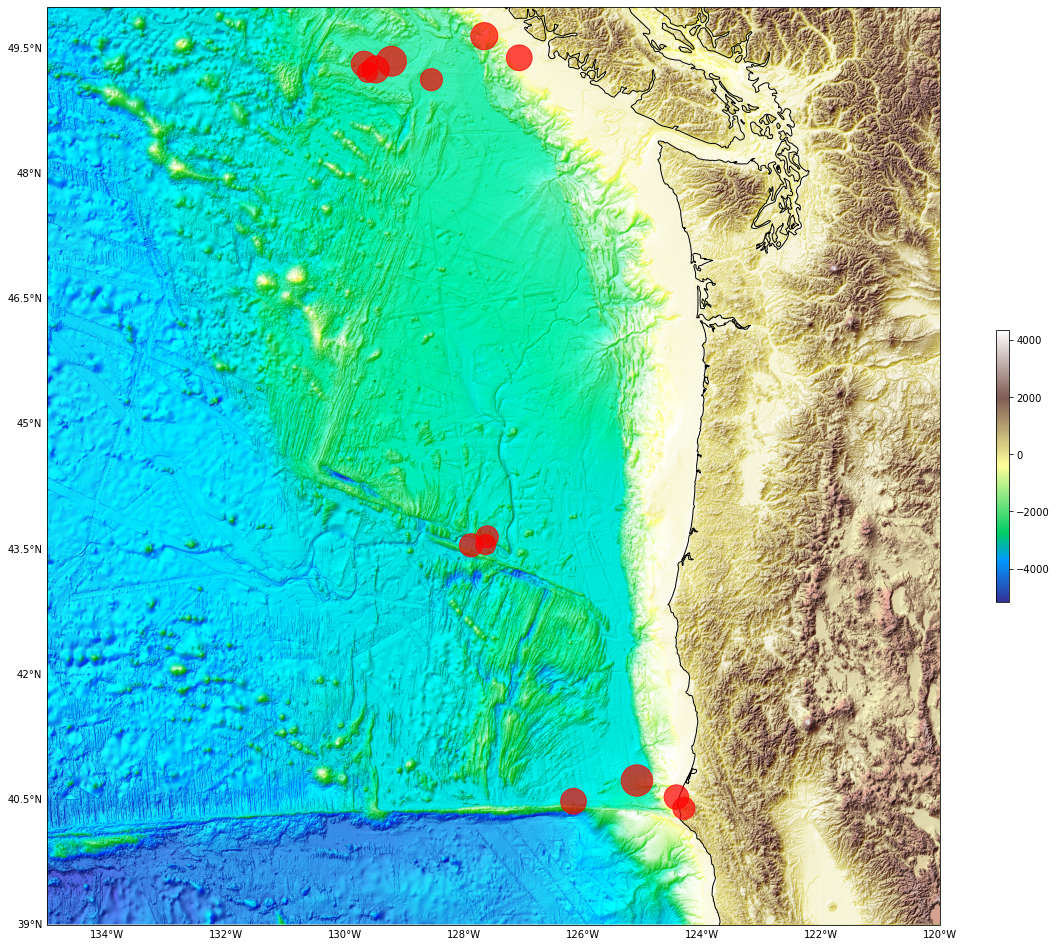

In [21]:
plt.figure(figsize=(20,20))

ax=plot_elevation(x,y,z, shade=True) #shade=False is faster but less cool

ind= (events.longitude>min(x)) & (events.longitude<max(x)) & (events.latitude>min(y)) & (events.latitude<max(y)); # selecting only those points that are within our bathymetry area

plt.scatter(events[ind].longitude,
            events[ind].latitude,
            events[ind].marker_size, 
            color='r',alpha=0.7, 
            transform=ccrs.PlateCarree())

Do any features in the bathymetry stand out to you? Remember the diagram of geologic processes in the PNW above- do you think any of the bathymetric features connect to the geologic processes?

Let's see how our earthquake locations (which we previously saved as "lats" and "lons" arrays) relate to bathymetry.

# In-class exercise \#2: Juan de Fuca - Earthquakes

We can see there aren't too many large earthquakes occurring throughout the whole region. To get a better sense of the full scope of activity, we should plot earthquakes of smaller magnitude.

Download earthquakes with a minimum magnitude of 2.5 for the chosen region from IRIS. Plot those earthquakes on the bathymetry map, with their size relating to magnitude.

In [16]:
#your solution goes here

We see that some of the earthquakes align with the bathymetric high that runs roughly north-south in the region. That is called the Juan de Fuca Ridge, a mid-ocean spreading ridge where new seafloor is created. 

But, we see there is actually more activity on the northern end of the ridge and on the features in the south that run roughly east-west. That is because the tectonic plate boundaries in these areas are transitioning between types, leading to break-up of the tectonic plates.

To the north, seafloor spreading intersects the Cascadia subduction zone and the Queen Charlotte transform fault, which lead to the formation of the Explorer microplate.

To the south, the Blanco and Mendocino transform zones also outline a smaller plate, the Gorda plate.

Check out the first paper in the "reading" section for more detail!

# Earthquakes and Slab Depth
 
Geophysical imaging techniques allow us to "see" into the earth and define the depth and shape of a tectonic plate as it subducts beneath another. 
 
This analysis has been compiled into a dataset of "slab depths" for subduction zones around the globe:

Hayes, G. P., Moore, G. L., Portner, D. E., Hearne, M., Flamme, H., Furtney, M., & Smoczyk, G. M. (2018). Slab2, a comprehensive subduction zone geometry model. Science, 362(6410), 58-61.
https://www.science.org/doi/full/10.1126/science.aat4723

Slab2 data is publicly available and can be downloaded at https://www.sciencebase.gov/catalog/item/5aa1b00ee4b0b1c392e86467/

<img src="Slab_depths.jpeg" width=800>

Here we will look at the depth of the Pacific plate as it subducts beneath Alaska and the Aleutian arc. The grd file has already been downloaded to this directory:

In [22]:
slab_data = 'alu_slab2_dep_02.23.18.grd'

In [23]:
minlat = 45
maxlat = 65
minlon = -200 # note- this is not best practice to put longitude as greater than 180 but some packages require it
maxlon = -145

slab=xr.open_dataset(slab_data)
x_slab=slab.x.values
y_slab=slab.y.values
z_slab=slab.z.values
z_slab=np.flipud(z_slab)
z_slab[np.isnan(z_slab)]=0

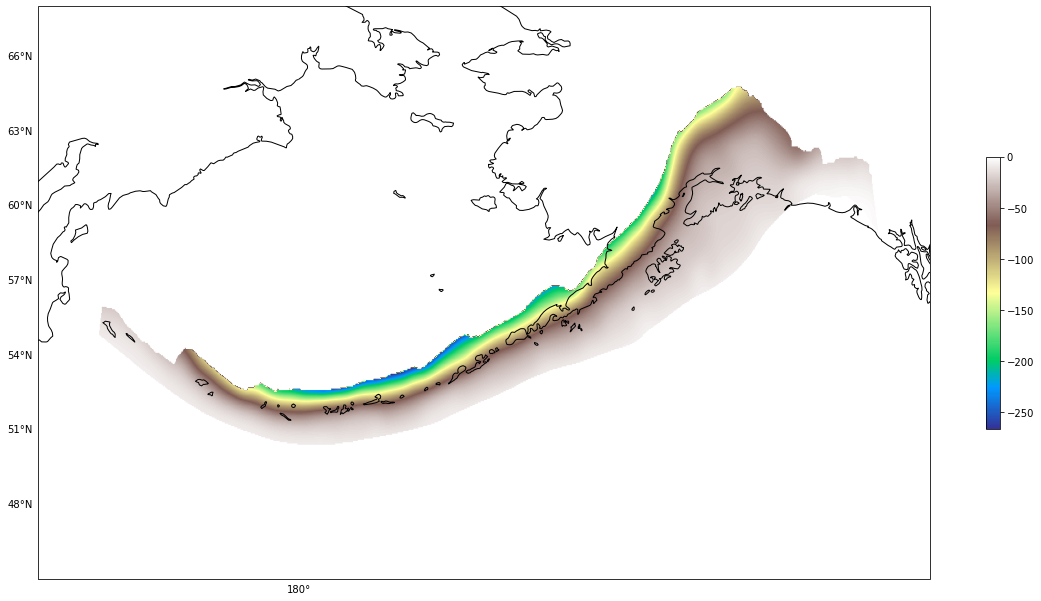

In [25]:
plt.figure(figsize=(20,20))
ax=plot_elevation(x_slab,y_slab,z_slab, shade=False)

Further reading about Alaskan seismicity: https://earthquake.alaska.edu/earthquakes/about

# In-class exercise \#3: Earthquake locations and slab depth
 
- Download and plot earthquake locations on top of the slab depth data.
- Is there any correspondence between slab depth and earthquake properties?


In [20]:
#your solution goes here

## Take-home exercise: slab depth vs earthquake depth

Figure out the depth of earthquakes with respect to slab depth

Instructions:
 - use xarray to sample the slab values at lat/lon locations of the earthquakes 
 - make a scatter plot of earthquake depth vs slab depth and plot a 1:1 line for reference

In [21]:
# your solution goes here